In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report

In [49]:
# Load the prepared data
data_dir = os.path.join(os.path.dirname(os.getcwd()), 'data', 'processed')

def load_data_generator(X_file_path, y_file_path, batch_size=32):
    def generator():
        X = np.load(X_file_path)
        y = np.load(y_file_path)
        for i in range(0, len(X), batch_size):
            yield X[i:i+batch_size], y[i:i+batch_size]
    
    # Determine the shape and type of a single example
    X_sample = np.load(X_file_path, mmap_mode='r')
    y_sample = np.load(y_file_path, mmap_mode='r')
    
    sample_shape = X_sample[0].shape
    sample_type = X_sample.dtype
    label_shape = y_sample[0].shape if len(y_sample.shape) > 1 else ()
    label_type = y_sample.dtype
    
    return tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(None,) + sample_shape, dtype=sample_type),
            tf.TensorSpec(shape=(None,) + label_shape, dtype=label_type)
        )
    )

# Load the datasets
train_dataset = load_data_generator(
    os.path.join(data_dir, 'X_train.npy'),
    os.path.join(data_dir, 'y_train.npy'),
    batch_size=32
)
val_dataset = load_data_generator(
    os.path.join(data_dir, 'X_val.npy'),
    os.path.join(data_dir, 'y_val.npy'),
    batch_size=32
)
test_dataset = load_data_generator(
    os.path.join(data_dir, 'X_test.npy'),
    os.path.join(data_dir, 'y_test.npy'),
    batch_size=32
)

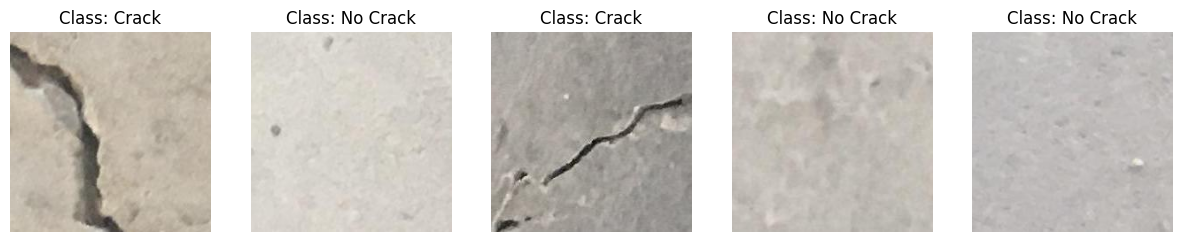

In [50]:
# Visualize some images
def visualize_images(X, y, num_images=5):
    plt.figure(figsize=(15, 3))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(X[i])
        plt.title(f"Class: {'Crack' if y[i] == 1 else 'No Crack'}")
        plt.axis('off')
    plt.show()

visualize_images(X_train, y_train)

In [51]:
# Check class balance
def check_class_balance(y):
    unique, counts = np.unique(y, return_counts=True)
    for label, count in zip(unique, counts):
        print(f"Class {label}: {count} ({count/len(y)*100:.2f}%)")

print("Class balance in training set:")
check_class_balance(y_train)

Class balance in training set:
Class 0: 3200 (50.00%)
Class 1: 3200 (50.00%)


In [52]:
# Define the model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(227, 227, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation='sigmoid')
])


In [54]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Compile the model
model.compile(optimizer=Adam(learning_rate=5e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [57]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset
)

Epoch 1/10
200/200 [==============================] - 18s 68ms/step - loss: 0.4436 - accuracy: 0.8555 - val_loss: 0.4093 - val_accuracy: 0.8750
Epoch 2/10
200/200 [==============================] - 17s 62ms/step - loss: 0.3929 - accuracy: 0.8856 - val_loss: 0.3599 - val_accuracy: 0.9038
Epoch 3/10
200/200 [==============================] - 16s 62ms/step - loss: 0.3454 - accuracy: 0.9100 - val_loss: 0.3171 - val_accuracy: 0.9219
Epoch 4/10
200/200 [==============================] - 16s 63ms/step - loss: 0.3039 - accuracy: 0.9242 - val_loss: 0.2786 - val_accuracy: 0.9312
Epoch 5/10
200/200 [==============================] - 17s 62ms/step - loss: 0.2687 - accuracy: 0.9345 - val_loss: 0.2482 - val_accuracy: 0.9350
Epoch 6/10
200/200 [==============================] - 16s 62ms/step - loss: 0.2409 - accuracy: 0.9409 - val_loss: 0.2238 - val_accuracy: 0.9456
Epoch 7/10
200/200 [==============================] - 17s 62ms/step - loss: 0.2187 - accuracy: 0.9452 - val_loss: 0.2040 - val_accuracy:

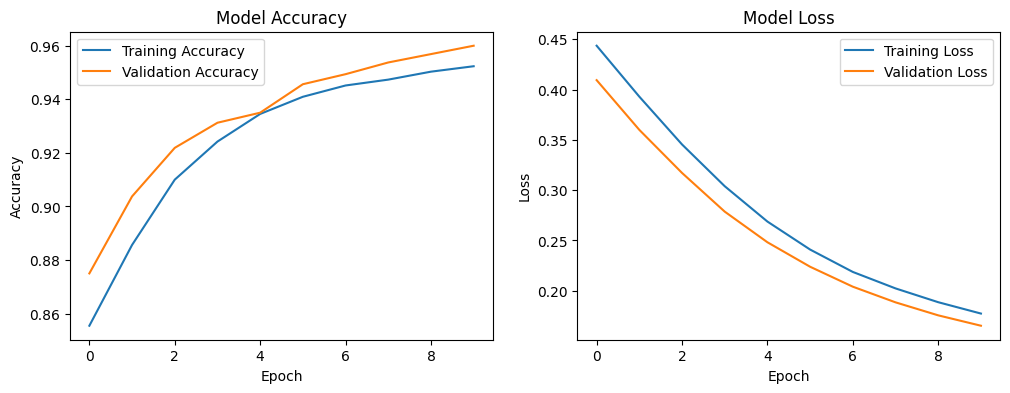

In [58]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [59]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc:.4f}')

63/63 [==============================] - 1s 16ms/step - loss: 0.1534 - accuracy: 0.9620
Test accuracy: 0.9620


In [61]:
# Make predictions on the test set
y_pred = model.predict(test_dataset)
y_pred_classes = (y_pred > 0.5).astype(int)

63/63 [==============================] - 3s 18ms/step


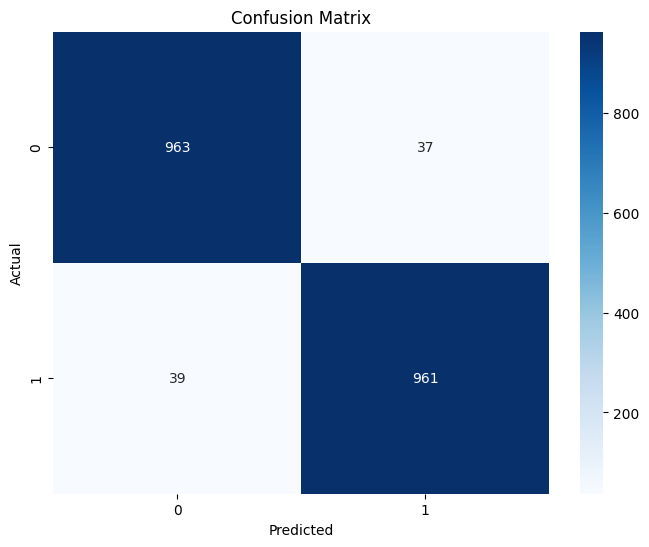

In [62]:
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [63]:
# Print classification report
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1000
           1       0.96      0.96      0.96      1000

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000



In [64]:
model.save('concrete_crack_detection_v4.h5')